<a href="https://colab.research.google.com/github/alexcodechallenge/pytorchresearch-/blob/master/DenseNet-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
class ConvPool(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(ConvPool, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

In [3]:
class CompositeLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(CompositeLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        "Bottleneck function"
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    def forward(self, input):  # noqa: F811
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

In [4]:
class Block(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(Block, self).__init__()
        for i in range(num_layers):
            layer = CompositeLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

In [5]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # Convolution and pooling part from table-1
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Add multiple denseblocks based on config 
        # for densenet-121 config: [6,12,24,16]
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = Block(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = ConvPool(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [6]:
def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model

def densenet121(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, validationset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, pin_memory=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=1024,
                                          shuffle=False, pin_memory=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, pin_memory=True, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
writer = SummaryWriter('runs/cifar10')
model = densenet121() #DenseNet((4, 8), num_init_features=128, num_hidden_features=256, num_output_features=256, num_classes=10)
writer.add_graph(model, torch.randn(1, 3, 32, 32))
writer.close()

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model).to(device)
else:
    model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def get_acc(model, loader):
    with torch.no_grad():
        correct = 0
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            correct += (labels == outputs.argmax(dim=1).squeeze()).sum()
        acc = float(correct) / len(loader.dataset)
    return acc

In [10]:
num_epochs = 10
eval_every = 100
train_acc_his = []
val_acc_his = []
test_acc_his = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        if i==0 or (i+1) % eval_every == 0:
            train_acc = get_acc(model, trainloader)
            val_acc = get_acc(model, validationloader)
            test_acc = get_acc(model, testloader)
            train_acc_his.append(train_acc)
            val_acc_his.append(val_acc)
            test_acc_his.append(test_acc)
            writer.add_scalar('train_acc', train_acc, len(train_acc_his))
            writer.add_scalar('val_acc', val_acc, len(val_acc_his))
            writer.add_scalar('test_acc', test_acc, len(test_acc_his))
            print('[epoch %d, iter %d] train_acc: %.3f  val_acc: %.3f  test_acc: %.3f' %
                  (epoch+1, i+1, train_acc, val_acc, test_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[epoch 1, iter 1] train_acc: 0.183  val_acc: 0.177  test_acc: 0.182
[epoch 1, iter 100] train_acc: 0.418  val_acc: 0.418  test_acc: 0.424
[epoch 2, iter 1] train_acc: 0.452  val_acc: 0.445  test_acc: 0.448
[epoch 2, iter 100] train_acc: 0.540  val_acc: 0.527  test_acc: 0.532
[epoch 3, iter 1] train_acc: 0.548  val_acc: 0.536  test_acc: 0.535
[epoch 3, iter 100] train_acc: 0.621  val_acc: 0.597  test_acc: 0.605
[epoch 4, iter 1] train_acc: 0.645  val_acc: 0.627  test_acc: 0.626
[epoch 4, iter 100] train_acc: 0.667  val_acc: 0.636  test_acc: 0.641
[epoch 5, iter 1] train_acc: 0.684  val_acc: 0.653  test_acc: 0.657
[epoch 5, iter 100] train_acc: 0.743  val_acc: 0.696  test_acc: 0.699
[epoch 6, iter 1] train_acc: 0.749  val_acc: 0.698  test_acc: 0.701
[epoch 6, iter 100] train_acc: 0.774  val_acc: 0.715  test_acc: 0.715
[epoch 7, iter 1] train_acc: 0.774  val_acc: 0.711  test_acc: 0.711
[epoch 7, iter 100] train_acc: 0.812  val_acc: 0.735  test_acc: 0.741
[epoch 8, iter 1] train_acc: 0.807

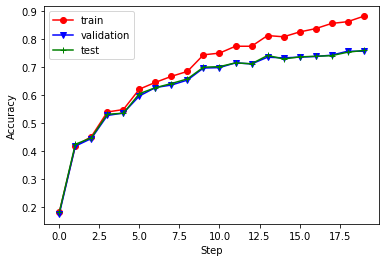

In [11]:
plt.plot(train_acc_his, 'ro-', label='train')
plt.plot(val_acc_his, 'bv-', label='validation')
plt.plot(test_acc_his, 'g+-', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.legend()
plt.show()